In [1]:
import sys
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.metrics import (
    f1_score, precision_score, recall_score, 
    accuracy_score, classification_report, confusion_matrix,
    silhouette_score, adjusted_rand_score, normalized_mutual_info_score
)
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Check for mRMR
try:
    from mrmr import mrmr_classif
    HAS_MRMR = True
except ImportError:
    HAS_MRMR = False
    print("Warning: mrmr-selection not installed. Will skip mRMR step.")

# Check for UMAP
try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False
    print("Warning: umap-learn not installed. UMAP plots will be skipped.")

# Check for GPU
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f">>> Running on: {DEVICE}")

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Check for CuPy (GPU mRMR)
try:
    import cupy as cp
    HAS_CUPY = True
    print(">>> CuPy detected. GPU mRMR enabled.")
except ImportError:
    HAS_CUPY = False
    print(">>> CuPy NOT detected. GPU mRMR disabled.")


>>> Running on: cuda
>>> CuPy detected. GPU mRMR enabled.


In [2]:
# --- BEST HYPERPARAMETERS (From Optuna) ---
BEST_PARAMS = {
    'latent_dim': 32, 
    'hidden_dim': 128, 
    'fusion_hidden_dim': 64, 
    'dropout_encoder': 0.36417418768390764, 
    'dropout_rate': 0.1442749864247061, 
    'lr_fine': 0.0007569791124438231, 
    'weight_decay': 0.00015232369068221064, 
    'noise_level': 0.029638435639971566, 
    'focal_gamma': 3.694862858774165, 
    'alpha_scale': 2.3380598469529907
}

In [3]:
class PerOmicCMAE(nn.Module):
    """Encoder for Supervised Learning"""
    def __init__(self, input_dim, latent_dim=64, hidden_dim=256, dropout_encoder=0.0):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim), 
            nn.GELU(),
            nn.Dropout(dropout_encoder),
            nn.Linear(hidden_dim, latent_dim)
        )

    def forward(self, x, noise_level=0.0, noise_type='gaussian'):
        # Noise Injection during training
        if self.training and noise_level > 0:
            if noise_type == 'gaussian':
                noise = torch.randn_like(x) * noise_level
                x_corrupted = x + noise
            elif noise_type == 'uniform':
                noise = (torch.rand_like(x) - 0.5) * 2 * noise_level
                x_corrupted = x + noise
            elif noise_type == 'dropout':
                mask = torch.bernoulli(torch.ones_like(x) * (1 - noise_level))
                x_corrupted = x * mask
            else:
                x_corrupted = x
        else:
            x_corrupted = x

        z = self.encoder(x_corrupted)
        return z


class GatedAttentionFusion(nn.Module):
    """Gated Attention Fusion"""
    def __init__(self, latent_dim=64, num_classes=4, dropout_rate=0.3, hidden_dim=64):
        super().__init__()
        self.gate_rna = nn.Linear(latent_dim, 1)
        self.gate_meth = nn.Linear(latent_dim, 1)
        self.gate_clin = nn.Linear(latent_dim, 1) 
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )
        self.drop_rate = dropout_rate

    def forward(self, z_rna, z_meth, z_clin, apply_dropout=False):
        if apply_dropout and self.training:
            if torch.rand(1).item() < self.drop_rate: z_rna = torch.zeros_like(z_rna)
            if torch.rand(1).item() < self.drop_rate: z_meth = torch.zeros_like(z_meth)
            if torch.rand(1).item() < self.drop_rate: z_clin = torch.zeros_like(z_clin)

        w_rna = torch.sigmoid(self.gate_rna(z_rna))
        w_meth = torch.sigmoid(self.gate_meth(z_meth))
        w_clin = torch.sigmoid(self.gate_clin(z_clin))

        z_fused = torch.cat([w_rna * z_rna, w_meth * z_meth, w_clin * z_clin], dim=1)
        
        return self.classifier(z_fused), z_fused


class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_weight = (1 - pt) ** self.gamma
        focal_loss = focal_weight * ce_loss
        
        if self.alpha is not None:
            if isinstance(self.alpha, (float, int)):
                alpha_t = self.alpha
            else:
                if self.alpha.device != inputs.device:
                    self.alpha = self.alpha.to(inputs.device)
                alpha_t = self.alpha.gather(0, targets)
            focal_loss = alpha_t * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [4]:
def load_raw_aligned_data():
    print(f"\n>>> LOADING RAW ALIGNED DATA")
    pheno_path = "Data/phenotype_clean.csv"
    if not os.path.exists(pheno_path):
        raise FileNotFoundError(f"{pheno_path} not found.")

    pheno = pd.read_csv(pheno_path, index_col=0)
    SUBTYPES_OF_INTEREST = [
        'Leiomyosarcoma, NOS', 'Dedifferentiated liposarcoma',
        'Undifferentiated sarcoma', 'Fibromyxosarcoma'
    ]
    col_name = 'primary_diagnosis.diagnoses'
    mask = pheno[col_name].isin(SUBTYPES_OF_INTEREST)
    pheno = pheno[mask]

    def load_omic(path, name):
        if not os.path.exists(path): return None
        df = pd.read_csv(path, index_col=0)
        df = df.T  # samples x features
        return df

    rna = load_omic("Data/expression_log.csv", "RNA")
    meth = load_omic("Data/methylation_mvalues.csv", "Methylation")
    cnv = load_omic("Data/cnv_log.csv", "CNV")

    common_samples = pheno.index.intersection(rna.index).intersection(meth.index).intersection(cnv.index)
    print(f"  Common Samples: {len(common_samples)}")

    pheno = pheno.loc[common_samples]
    rna = rna.loc[common_samples]
    meth = meth.loc[common_samples]
    cnv = cnv.loc[common_samples]

    le = LabelEncoder()
    Y = le.fit_transform(pheno[col_name])
    
    class_counts = np.bincount(Y)
    class_weights = len(Y) / (len(class_counts) * class_counts)
    class_weights = class_weights / class_weights.sum()
    
    return rna, meth, cnv, Y, le.classes_, class_weights

In [5]:
# --- Advanced Feature Preparation Helpers ---
import time

def f_classif_gpu(X, y):
    """Compute ANOVA F-value on GPU."""
    n_samples, n_features = X.shape
    classes = cp.unique(y)
    n_classes = len(classes)
    
    mean_total = cp.mean(X, axis=0)
    var_total = cp.var(X, axis=0)
    ss_total = var_total * n_samples
    
    ss_between = cp.zeros(n_features, dtype=cp.float32)
    
    for c in classes:
        mask = (y == c)
        n_c = cp.sum(mask)
        mean_c = cp.mean(X[mask], axis=0)
        ss_between += n_c * (mean_c - mean_total)**2
        
    ss_within = ss_total - ss_between
    
    df_between = n_classes - 1
    df_within = n_samples - n_classes
    
    ms_between = ss_between / df_between
    ms_within = ss_within / df_within
    
    f_stat = cp.divide(ms_between, ms_within)
    f_stat = cp.nan_to_num(f_stat, nan=0.0)
    return f_stat

def correlation_gpu(X, y):
    """Compute Pearson correlation on GPU."""
    X_centered = X - X.mean(axis=0)
    y_centered = y - y.mean()
    
    numerator = cp.dot(y_centered, X_centered)
    X_ss = cp.sum(X_centered**2, axis=0)
    y_ss = cp.sum(y_centered**2)
    
    denominator = cp.sqrt(X_ss * y_ss)
    corr = numerator / denominator
    return cp.abs(corr)

def mrmr_gpu_impl(X, y, K):
    """GPU accelerated mRMR."""
    # Move to GPU if not already
    X_gpu = cp.asarray(X, dtype=cp.float32)
    y_gpu = cp.asarray(y, dtype=cp.int32)
    
    n_samples, n_features = X_gpu.shape
    
    # 1. Relevance
    relevance = f_classif_gpu(X_gpu, y_gpu)
    
    selected_indices = []
    candidate_mask = cp.ones(n_features, dtype=bool)
    redundancy = cp.zeros(n_features, dtype=cp.float32)
    
    for k in range(K):
        if k == 0:
            scores = relevance
        else:
            scores = relevance - (redundancy / k)
            
        current_scores = scores.copy()
        current_scores[~candidate_mask] = -np.inf 
        
        best_idx = int(cp.argmax(current_scores))
        selected_indices.append(best_idx)
        candidate_mask[best_idx] = False
        
        if k < K - 1:
            last_selected_feature = X_gpu[:, best_idx]
            new_corrs = correlation_gpu(X_gpu, last_selected_feature)
            redundancy += new_corrs
            
    return selected_indices

def variance_filter(train_vals, val_vals, top_k):
    """Filter features by variance, calculated on train data only."""
    if train_vals.shape[1] <= top_k:
        return train_vals, val_vals, np.arange(train_vals.shape[1])
    
    # Use nanvar to be safe against NaNs
    vars = np.nanvar(train_vals, axis=0)
    # Indices of top_k variance
    top_idx = np.argpartition(vars, -top_k)[-top_k:]
    # Sort indices to keep order (optional but nice)
    top_idx = np.sort(top_idx)
    
    return train_vals[:, top_idx], val_vals[:, top_idx], top_idx

def mrmr_filter(train_vals, val_vals, train_y, top_k, feat_names):
    """Apply mRMR feature selection on Training data, apply to Validation."""
    if train_vals.shape[1] <= top_k:
        return train_vals, val_vals, np.arange(train_vals.shape[1])
        
    # GPU ACCELERATION
    if HAS_CUPY:
        try:
            # print(f"   [GPU] Running mRMR on {train_vals.shape}...")
            selected_indices = mrmr_gpu_impl(train_vals, train_y, top_k)
            # Ensure indices are python list of ints
            if hasattr(selected_indices, 'get'): selected_indices = selected_indices.get()
            selected_indices = list(selected_indices)
            
            return train_vals[:, selected_indices], val_vals[:, selected_indices], selected_indices
        except Exception as e:
            print(f"   [GPU] mRMR Failed: {e}. Falling back to CPU.")
            # Fallthrough to CPU
            
    if not HAS_MRMR: 
        return variance_filter(train_vals, val_vals, top_k) # Fallback
    
    # mRMR requires DataFrame with columns
    df_train = pd.DataFrame(train_vals, columns=[f"f_{i}" for i in range(train_vals.shape[1])])
    y_series = pd.Series(train_y)
    
    # Select features
    selected_feats = mrmr_classif(X=df_train, y=y_series, K=top_k, show_progress=False)
    
    # Map back to indices
    selected_indices = [int(f.split('_')[1]) for f in selected_feats]
    
    return train_vals[:, selected_indices], val_vals[:, selected_indices], selected_indices

def prepare_fold_data_advanced(t_idx, v_idx, df_rna, df_meth, df_cnv, Y):
    """Pipeline: Variance (Top 5k) -> KNN Impute -> mRMR (Top 600) -> Scale"""
    
    # 1. Split
    tr_r, val_r = df_rna.iloc[t_idx].values, df_rna.iloc[v_idx].values
    tr_m, val_m = df_meth.iloc[t_idx].values, df_meth.iloc[v_idx].values
    tr_c, val_c = df_cnv.iloc[t_idx].values, df_cnv.iloc[v_idx].values
    y_tr = Y[t_idx]
    
    # 2. Variance Filter (Speed up KNN)
    # Methylation is huge, filter heavily first. Others less so.
    tr_r, val_r, _ = variance_filter(tr_r, val_r, top_k=4000)
    tr_m, val_m, _ = variance_filter(tr_m, val_m, top_k=10000)
    tr_c, val_c, _ = variance_filter(tr_c, val_c, top_k=4000)
    
    # 3. KNN Imputation
    imp = KNNImputer(n_neighbors=12)
    tr_r = imp.fit_transform(tr_r); val_r = imp.transform(val_r)
    tr_m = imp.fit_transform(tr_m); val_m = imp.transform(val_m)
    tr_c = imp.fit_transform(tr_c); val_c = imp.transform(val_c)
    
    # 4. mRMR Feature Selection (Refine for Relevance)
    # Target dimensions similar to source paper or reasonable dense input
    tr_r, val_r, _ = mrmr_filter(tr_r, val_r, y_tr, top_k=300, feat_names=None)
    tr_m, val_m, _ = mrmr_filter(tr_m, val_m, y_tr, top_k=600, feat_names=None)
    tr_c, val_c, _ = mrmr_filter(tr_c, val_c, y_tr, top_k=200, feat_names=None)
    
    # 5. Standard Scaling
    sc = StandardScaler()
    tr_r = sc.fit_transform(tr_r); val_r = sc.transform(val_r)
    tr_m = sc.fit_transform(tr_m); val_m = sc.transform(val_m)
    tr_c = sc.fit_transform(tr_c); val_c = sc.transform(val_c)
    
    return (
        torch.FloatTensor(tr_r).to(DEVICE), torch.FloatTensor(val_r).to(DEVICE), tr_r.shape[1],
        torch.FloatTensor(tr_m).to(DEVICE), torch.FloatTensor(val_m).to(DEVICE), tr_m.shape[1],
        torch.FloatTensor(tr_c).to(DEVICE), torch.FloatTensor(val_c).to(DEVICE), tr_c.shape[1],
        torch.LongTensor(y_tr).to(DEVICE), torch.LongTensor(Y[v_idx]).to(DEVICE)
    )


In [6]:
def run_final_evaluation(rna_df, meth_df, cnv_df, Y, class_names, class_weights, params):
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    
    # Storage for analysis
    all_preds = np.zeros(len(Y))
    all_targets = np.zeros(len(Y))
    all_latent = np.zeros((len(Y), params['latent_dim']*3)) # Concatenated latent space for visualization
    
    metrics = {
        'f1_macro': [], 'f1_micro': [], 'precision': [], 'recall': [], 'accuracy': []
    }
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(rna_df, Y)):
        print(f"\n{'='*20} Fold {fold+1} / 5 {'='*20}")
        
        # Data Prep
        (tr_r, val_r, dim_r, 
         tr_m, val_m, dim_m, 
         tr_c, val_c, dim_c, 
         y_tr, y_val) = prepare_fold_data_advanced(train_idx, val_idx, rna_df, meth_df, cnv_df, Y)
        
        print(f"   Input Dims: RNA={dim_r}, Meth={dim_m}, CNV={dim_c}")
        
        # Model Init
        enc_r = PerOmicCMAE(dim_r, params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)
        enc_m = PerOmicCMAE(dim_m, params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)
        enc_c = PerOmicCMAE(dim_c, params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)
        fusion = GatedAttentionFusion(params['latent_dim'], len(class_names), params['dropout_rate'], params['fusion_hidden_dim']).to(DEVICE)
        
        optimizer = optim.AdamW(
            list(enc_r.parameters()) + list(enc_m.parameters()) + 
            list(enc_c.parameters()) + list(fusion.parameters()),
            lr=params['lr_fine'], weight_decay=params['weight_decay']
        )
        
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        alpha = torch.FloatTensor(class_weights * params['alpha_scale']).to(DEVICE)
        criterion = FocalLoss(gamma=params['focal_gamma'], alpha=alpha)
        
        # Training
        best_loss = float('inf')
        patience = 20
        cur_pat = 0
        best_state = None
        
        for epoch in range(300):
            enc_r.train(); enc_m.train(); enc_c.train(); fusion.train()
            
            z_r = enc_r(tr_r, noise_level=params['noise_level'])
            z_m = enc_m(tr_m, noise_level=params['noise_level'])
            z_c = enc_c(tr_c, noise_level=params['noise_level'])
            
            logits, _ = fusion(z_r, z_m, z_c, apply_dropout=True)
            loss = criterion(logits, y_tr)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Validation
            enc_r.eval(); enc_m.eval(); enc_c.eval(); fusion.eval()
            with torch.no_grad():
                v_z_r = enc_r(val_r)
                v_z_m = enc_m(val_m)
                v_z_c = enc_c(val_c)
                v_logits, v_latent = fusion(v_z_r, v_z_m, v_z_c)
                val_loss = criterion(v_logits, y_val).item()
                
            scheduler.step(val_loss)
            
            if val_loss < best_loss:
                best_loss = val_loss
                cur_pat = 0
                # Save Predictions for Best Epoch
                v_preds = v_logits.argmax(dim=1).cpu().numpy()
                v_targets = y_val.cpu().numpy()
                v_embeddings = v_latent.cpu().numpy()
            else:
                cur_pat += 1
            
            if cur_pat >= patience:
                break
        
        # Record Fold Results
        all_preds[val_idx] = v_preds
        all_targets[val_idx] = v_targets
        all_latent[val_idx] = v_embeddings
        
        f1_mac = f1_score(v_targets, v_preds, average='macro')
        acc = accuracy_score(v_targets, v_preds)
        
        metrics['f1_macro'].append(f1_mac)
        metrics['f1_micro'].append(f1_score(v_targets, v_preds, average='micro'))
        metrics['precision'].append(precision_score(v_targets, v_preds, average='macro'))
        metrics['recall'].append(recall_score(v_targets, v_preds, average='macro'))
        metrics['accuracy'].append(acc)
        
        print(f"   Fold Result: F1-Macro={f1_mac:.4f}, Accuracy={acc:.4f}")

    return metrics, all_preds, all_targets, all_latent

In [7]:
# Load Data
try:
    rna_df, meth_df, cnv_df, Y, class_names, class_weights = load_raw_aligned_data()
    
    # Run Eval
    metrics, all_preds, all_targets, all_latent = run_final_evaluation(
        rna_df, meth_df, cnv_df, Y, class_names, class_weights, BEST_PARAMS
    )
    
    # --- Reporting ---
    print(f"\n{'='*30}")
    print("FINAL CLASSIFICATION METRICS")
    print(f"{'='*30}")
    print(f"F1 Macro:  {np.mean(metrics['f1_macro']):.4f} (+/- {np.std(metrics['f1_macro']):.4f})")
    print(f"F1 Micro:  {np.mean(metrics['f1_micro']):.4f} (+/- {np.std(metrics['f1_micro']):.4f})")
    print(f"Precision: {np.mean(metrics['precision']):.4f}")
    print(f"Recall:    {np.mean(metrics['recall']):.4f}")
    print(f"Accuracy:  {np.mean(metrics['accuracy']):.4f}")
    
    # --- Clustering Metrics ---
    print(f"\n{'='*30}")
    print("CLUSTERING METRICS (Latent Space)")
    print(f"{'='*30}")
    
    # 1. True Labels Silhouette
    sil_true = silhouette_score(all_latent, all_targets)
    print(f"Silhouette Score (True Labels): {sil_true:.4f}")
    
    # 2. K-Means Clustering
    kmeans = KMeans(n_clusters=len(class_names), random_state=SEED)
    kmeans_preds = kmeans.fit_predict(all_latent)
    
    sil_km = silhouette_score(all_latent, kmeans_preds)
    ari = adjusted_rand_score(all_targets, kmeans_preds)
    nmi = normalized_mutual_info_score(all_targets, kmeans_preds)
    
    print(f"Silhouette Score (K-Means):   {sil_km:.4f}")
    print(f"Adjusted Rand Index (ARI):    {ari:.4f}")
    print(f"Normalized Mutual Info (NMI): {nmi:.4f}")

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()


>>> LOADING RAW ALIGNED DATA
  Common Samples: 205

==================== Fold 1 / 5 ====================
   Input Dims: RNA=300, Meth=600, CNV=200
   Fold Result: F1-Macro=0.7673, Accuracy=0.8537

==================== Fold 2 / 5 ====================
   Input Dims: RNA=300, Meth=600, CNV=200
   Fold Result: F1-Macro=0.8542, Accuracy=0.9024

==================== Fold 3 / 5 ====================
   Input Dims: RNA=300, Meth=600, CNV=200
   Fold Result: F1-Macro=0.6754, Accuracy=0.7317

==================== Fold 4 / 5 ====================
   Input Dims: RNA=300, Meth=600, CNV=200
   Fold Result: F1-Macro=0.7237, Accuracy=0.8049

==================== Fold 5 / 5 ====================
   Input Dims: RNA=300, Meth=600, CNV=200
   Fold Result: F1-Macro=0.7330, Accuracy=0.7805

FINAL CLASSIFICATION METRICS
F1 Macro:  0.7507 (+/- 0.0595)
F1 Micro:  0.8146 (+/- 0.0589)
Precision: 0.7572
Recall:    0.7683
Accuracy:  0.8146

CLUSTERING METRICS (Latent Space)
Silhouette Score (True Labels): 0.0447
Sil

Running t-SNE...
Running UMAP...


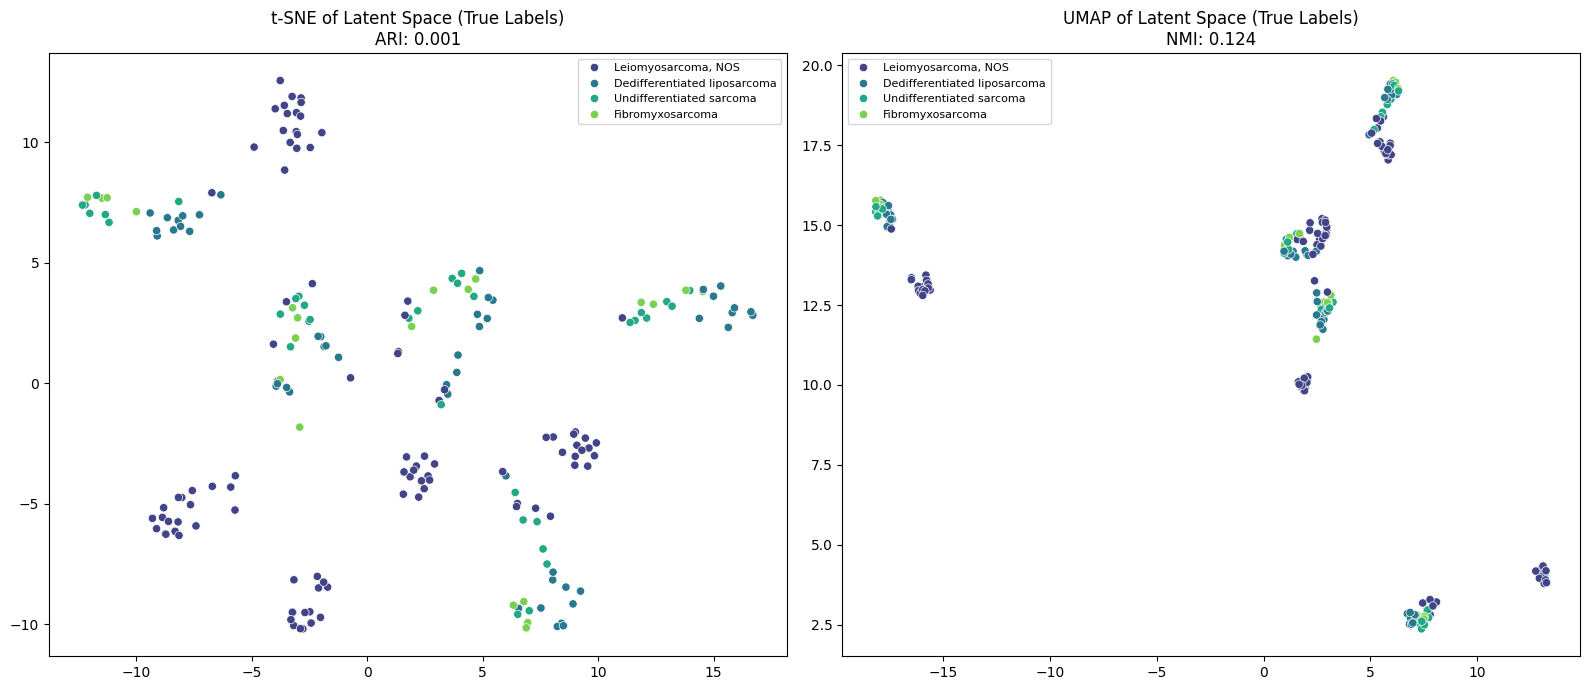

In [8]:
# --- Visualizations ---
plt.style.use('default')
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# TSNE
print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30)
z_tsne = tsne.fit_transform(all_latent)

sns.scatterplot(
    x=z_tsne[:,0], y=z_tsne[:,1], 
    hue=[class_names[int(i)] for i in all_targets], 
    palette='viridis', ax=axes[0]
)
axes[0].set_title(f't-SNE of Latent Space (True Labels)\nARI: {ari:.3f}')
axes[0].legend(prop={'size': 8})

# UMAP (if available)
if HAS_UMAP:
    print("Running UMAP...")
    reducer = umap.UMAP(random_state=SEED)
    z_umap = reducer.fit_transform(all_latent)
    
    sns.scatterplot(
        x=z_umap[:,0], y=z_umap[:,1], 
        hue=[class_names[int(i)] for i in all_targets], 
        palette='viridis', ax=axes[1]
    )
    axes[1].set_title(f'UMAP of Latent Space (True Labels)\nNMI: {nmi:.3f}')
    axes[1].legend(prop={'size': 8})
else:
    axes[1].text(0.5, 0.5, 'UMAP Not Installed', ha='center')

plt.tight_layout()
plt.savefig('cluster_analysis.png', dpi=300)
plt.show()


STARTING PREPROCESSING ABLATION (5 Scenarios)

>>> Testing: Baseline (Var+KNN+mRMR)
   -> Result: F1-Macro = 0.6785 (+/- 0.0904)

>>> Testing: Simple Imputation (Mean)
   -> Result: F1-Macro = 0.6998 (+/- 0.1028)

>>> Testing: ANOVA Selection (No mRMR)
   -> Result: F1-Macro = 0.6844 (+/- 0.0671)

>>> Testing: No Feature Selection
   -> Result: F1-Macro = 0.7523 (+/- 0.0913)

>>> Testing: No Variance Filter
   -> Result: F1-Macro = 0.7473 (+/- 0.1025)

PREPROCESSING ABLATION RESULTS
                 Scenario  F1_Macro  Std_Dev
     No Feature Selection  0.752330 0.091326
       No Variance Filter  0.747340 0.102469
 Simple Imputation (Mean)  0.699833 0.102767
ANOVA Selection (No mRMR)  0.684437 0.067102
  Baseline (Var+KNN+mRMR)  0.678542 0.090356


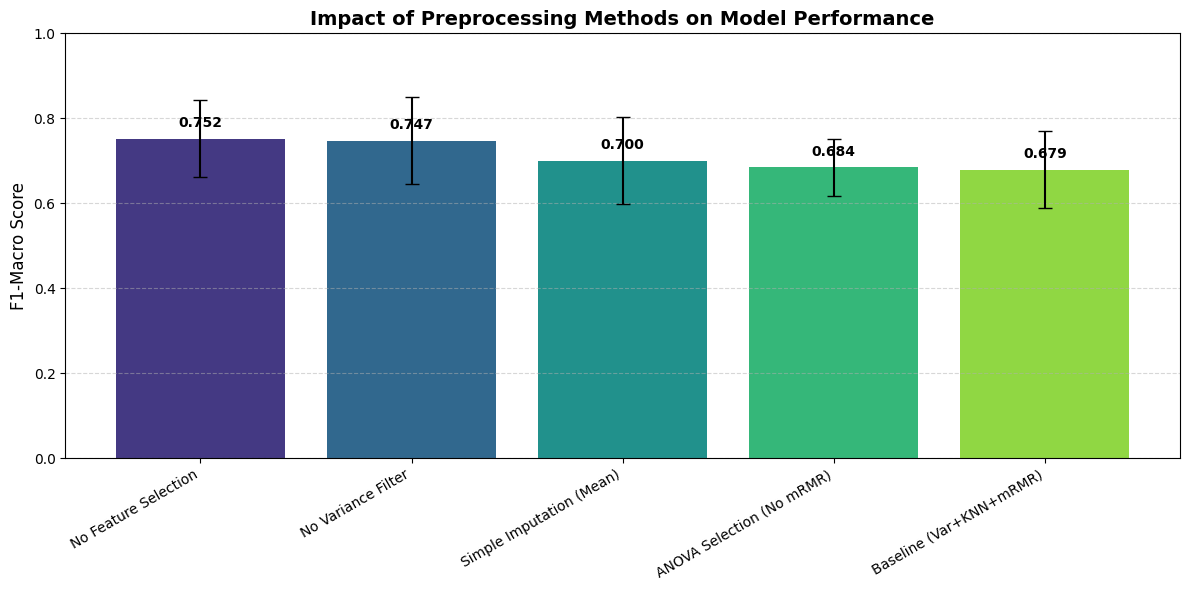

In [9]:
# [markdown]
# # Preprocessing Ablation Study
# This section evaluates the impact of data preprocessing choices (Imputation, Feature Selection, Filtering).
# We compare the "Baseline" (Variance -> KNN -> mRMR) against simpler alternatives.

# [code]
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif

def run_preprocessing_ablation(rna_df, meth_df, cnv_df, Y, class_names, params):
    
    # --- Define Scenarios ---
    scenarios = [
        {
            "name": "Baseline (Var+KNN+mRMR)",
            "impute": "knn",
            "select": "mrmr",
            "var_filter": True
        },
        {
            "name": "Simple Imputation (Mean)",
            "impute": "mean",   # Test: Does KNN actually help?
            "select": "mrmr",
            "var_filter": True
        },
        {
            "name": "ANOVA Selection (No mRMR)",
            "impute": "knn",
            "select": "anova",  # Test: Is mRMR better than simple F-test?
            "var_filter": True
        },
        {
            "name": "No Feature Selection",
            "impute": "knn",
            "select": "none",   # Test: Do we need selection at all?
            "var_filter": True
        },
        # Caution: 'No Variance Filter' might be slow due to high dimensionality
        {
            "name": "No Variance Filter", 
            "impute": "knn",
            "select": "mrmr",
            "var_filter": False 
        }
    ]
    
    results = []
    
    print(f"\n{'='*80}")
    print(f"STARTING PREPROCESSING ABLATION ({len(scenarios)} Scenarios)")
    print(f"{'='*80}")

    for scen in scenarios:
        print(f"\n>>> Testing: {scen['name']}")
        
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        fold_f1s = []
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(rna_df, Y)):
            
            # --- CUSTOM ABLATION DATA PREP ---
            # 1. Split
            tr_r, val_r = rna_df.iloc[train_idx].values, rna_df.iloc[val_idx].values
            tr_m, val_m = meth_df.iloc[train_idx].values, meth_df.iloc[val_idx].values
            tr_c, val_c = cnv_df.iloc[train_idx].values, cnv_df.iloc[val_idx].values
            y_tr = Y[train_idx]
            y_val = Y[val_idx]

            # 2. Variance Filter (Optional)
            if scen['var_filter']:
                tr_r, val_r, _ = variance_filter(tr_r, val_r, top_k=5000)
                tr_m, val_m, _ = variance_filter(tr_m, val_m, top_k=10000)
                tr_c, val_c, _ = variance_filter(tr_c, val_c, top_k=5000)
            
            # 3. Imputation (KNN vs Mean)
            if scen['impute'] == 'knn':
                imp = KNNImputer(n_neighbors=12)
            else:
                imp = SimpleImputer(strategy='mean')
                
            tr_r = imp.fit_transform(tr_r); val_r = imp.transform(val_r)
            tr_m = imp.fit_transform(tr_m); val_m = imp.transform(val_m)
            tr_c = imp.fit_transform(tr_c); val_c = imp.transform(val_c)
            
            # 4. Feature Selection (mRMR vs ANOVA vs None)
            target_k_r, target_k_m, target_k_c = 600, 800, 500
            
            if scen['select'] == 'mrmr':
                tr_r, val_r, _ = mrmr_filter(tr_r, val_r, y_tr, top_k=target_k_r, feat_names=None)
                tr_m, val_m, _ = mrmr_filter(tr_m, val_m, y_tr, top_k=target_k_m, feat_names=None)
                tr_c, val_c, _ = mrmr_filter(tr_c, val_c, y_tr, top_k=target_k_c, feat_names=None)
            
            elif scen['select'] == 'anova':
                def anova_filter(tr, val, y, k):
                    if tr.shape[1] <= k: return tr, val
                    selector = SelectKBest(f_classif, k=k)
                    tr_new = selector.fit_transform(tr, y)
                    val_new = selector.transform(val)
                    return tr_new, val_new
                
                tr_r, val_r = anova_filter(tr_r, val_r, y_tr, target_k_r)
                tr_m, val_m = anova_filter(tr_m, val_m, y_tr, target_k_m)
                tr_c, val_c = anova_filter(tr_c, val_c, y_tr, target_k_c)
                
            # If 'none', we just keep the Variance Filtered features (High Dim)

            # 5. Scaling
            sc = StandardScaler()
            tr_r = sc.fit_transform(tr_r); val_r = sc.transform(val_r)
            tr_m = sc.fit_transform(tr_m); val_m = sc.transform(val_m)
            tr_c = sc.fit_transform(tr_c); val_c = sc.transform(val_c)
            
            # Convert to Tensor
            t_tr_r = torch.FloatTensor(tr_r).to(DEVICE)
            t_val_r = torch.FloatTensor(val_r).to(DEVICE)
            t_tr_m = torch.FloatTensor(tr_m).to(DEVICE)
            t_val_m = torch.FloatTensor(val_m).to(DEVICE)
            t_tr_c = torch.FloatTensor(tr_c).to(DEVICE)
            t_val_c = torch.FloatTensor(val_c).to(DEVICE)
            t_y_tr = torch.LongTensor(y_tr).to(DEVICE)
            t_y_val = torch.LongTensor(y_val).to(DEVICE)

            # --- MODEL TRAINING (Simplified for Speed) ---
            # Re-init model for every fold
            enc_r = PerOmicCMAE(tr_r.shape[1], params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)
            enc_m = PerOmicCMAE(tr_m.shape[1], params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)
            enc_c = PerOmicCMAE(tr_c.shape[1], params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)
            fusion = GatedAttentionFusion(params['latent_dim'], len(class_names), params['dropout_rate'], params['fusion_hidden_dim']).to(DEVICE)
            
            opt = optim.AdamW(list(enc_r.parameters()) + list(enc_m.parameters()) + list(enc_c.parameters()) + list(fusion.parameters()),
                              lr=params['lr_fine'], weight_decay=params['weight_decay'])
            crit = nn.CrossEntropyLoss() # Simple CE for ablation speed
            
            # Quick Train Loop (Early Stopping)
            best_fold_f1 = 0
            patience = 15; cur_pat = 0
            
            for ep in range(200): # Max 200 epochs for ablation
                enc_r.train(); enc_m.train(); enc_c.train(); fusion.train()
                z_r = enc_r(t_tr_r); z_m = enc_m(t_tr_m); z_c = enc_c(t_tr_c)
                logits, _ = fusion(z_r, z_m, z_c, apply_dropout=True)
                loss = crit(logits, t_y_tr)
                opt.zero_grad(); loss.backward(); opt.step()
                
                # Eval
                enc_r.eval(); enc_m.eval(); enc_c.eval(); fusion.eval()
                with torch.no_grad():
                    vz_r = enc_r(t_val_r); vz_m = enc_m(t_val_m); vz_c = enc_c(t_val_c)
                    v_logits, _ = fusion(vz_r, vz_m, vz_c)
                    preds = v_logits.argmax(dim=1).cpu().numpy()
                    targets = t_y_val.cpu().numpy()
                    current_f1 = f1_score(targets, preds, average='macro')
                
                if current_f1 > best_fold_f1:
                    best_fold_f1 = current_f1
                    cur_pat = 0
                else:
                    cur_pat += 1
                    if cur_pat >= patience: break
            
            fold_f1s.append(best_fold_f1)
        
        mean_f1 = np.mean(fold_f1s)
        std_f1 = np.std(fold_f1s)
        print(f"   -> Result: F1-Macro = {mean_f1:.4f} (+/- {std_f1:.4f})")
        
        results.append({
            'Scenario': scen['name'],
            'F1_Macro': mean_f1,
            'Std_Dev': std_f1
        })
        
    return pd.DataFrame(results)

# Run the Ablation
ablation_res = run_preprocessing_ablation(rna_df, meth_df, cnv_df, Y, class_names, BEST_PARAMS)

# Visualization
print(f"\n{'='*60}")
print("PREPROCESSING ABLATION RESULTS")
print(f"{'='*60}")
print(ablation_res.sort_values(by='F1_Macro', ascending=False).to_string(index=False))

plt.figure(figsize=(12, 6))
# Sort for plotting
plot_df = ablation_res.sort_values(by='F1_Macro', ascending=False)
bars = plt.bar(plot_df['Scenario'], plot_df['F1_Macro'], yerr=plot_df['Std_Dev'], 
               capsize=5, color=sns.color_palette("viridis", len(plot_df)))

plt.title('Impact of Preprocessing Methods on Model Performance', fontsize=14, fontweight='bold')
plt.ylabel('F1-Macro Score', fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('preprocessing_ablation.png', dpi=300)
plt.show()